# Dataset preparing 

In [1]:
'''
Load libs
'''
import torch
import torchvision as tv
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

from skimage import io, transform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use('ggplot')
np.random.seed(42)

In [2]:
'''
Define data folders 
'''
imgs_dir = './ISIC/images'
mask_dir = './ISIC/masks'
info_filename = './ISIC/imagedata.csv'

In [3]:
'''
Load metadata
'''
info = pd.read_csv(info_filename)
info.tail()

,isic_id,age_approx,anatom_site_general,benign_malignant,diagnosis,diagnosis_confirm_type,melanocytic,sex
1995,ISIC_0001995,10.0,NaN,benign,nevus,single image expert consensus,True,female
1996,ISIC_0001996,15.0,NaN,benign,nevus,single image expert consensus,True,female
1997,ISIC_0001997,15.0,NaN,benign,nevus,single image expert consensus,True,female
1998,ISIC_0001998,15.0,NaN,benign,nevus,single image expert consensus,True,female
1999,ISIC_0001999,15.0,NaN,benign,nevus,single image expert consensus,True,female


In [4]:
def show_imgmask(img, mask, ax=None):
    if ax:
        ax.imshow(img)
        ax.imshow(mask, alpha=0.3)
    else:
        plt.imshow(img)
        plt.imshow(mask, alpha=0.3)
        plt.axis('off')
        plt.show()

./ISIC/images/ISIC_0000041.png
./ISIC/masks/ISIC_0000041_mask.png


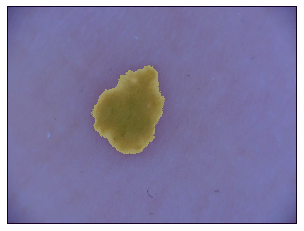

In [5]:
'''
Load one image and one mask
'''
index = 41

# Load image
img_filename = imgs_dir+'/'+info['isic_id'][index]+'.png'
print(img_filename)
img = io.imread(img_filename)

# Load mask
mask_filename = mask_dir+'/'+info['isic_id'][index]+'_mask.png'
print(mask_filename)
mask = io.imread(mask_filename)

show_imgmask(img, mask)

[0. 1.]


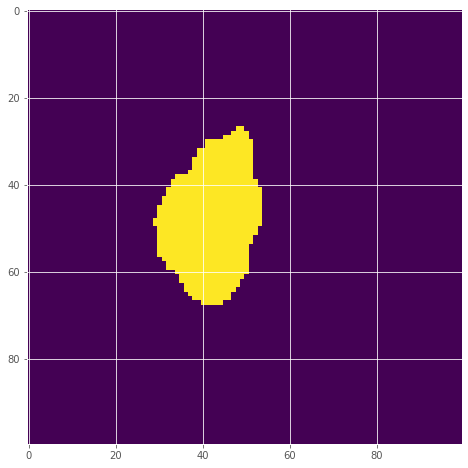

In [6]:
'''
Masks resizing demo (Rescale)
'''
re_mask = transform.resize(mask, (100,100))
re_mask = re_mask.round()
print(np.unique(re_mask))

plt.imshow(re_mask)
plt.show()

In [39]:
'''
Create a class for our dataset
'''

class ISICDataset(Dataset):
    '''ISIC images masks dataset'''
    
    def __init__(self, imgs_dir, mask_dir, info, transform=None):
        '''
        Args:
            imgs_dir (string): Directory with all images
            mask_dir (string): Directory with all masks
            info (DataFrame): csv file with information about images
            transform (callable, optional): Optional transform to be applied on a sample.
            split (int): how many 
        '''
        self.imgs_dir = imgs_dir
        self.mask_dir = mask_dir
        self.info = info
        self.transform = transform
    
    def __len__(self):
        return self.info.shape[0]
    
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        img_filename = self.imgs_dir+'/'+self.info['isic_id'][index]+'.png'
        mask_filename = self.mask_dir+'/'+self.info['isic_id'][index]+'_mask.png'
        
        image = io.imread(img_filename)
        mask = io.imread(mask_filename)
        
        sample = {'image': image, 'mask': mask}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
        

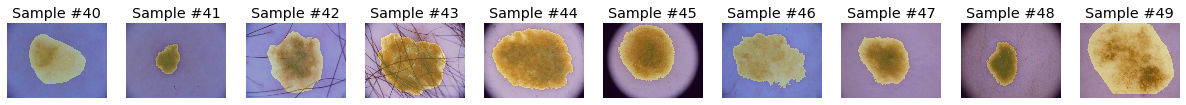

In [44]:
'''
Example of work ISICDataset class
'''
isic_dataset = ISICDataset(imgs_dir, mask_dir, info)

n_images = 10

fig, ax = plt.subplots(1,n_images, figsize=(21,12))
for i in range(n_images):
    index = i + 1
    sample = isic_dataset[index]
    
#     print(i, sample['image'].shape, sample['mask'].shape)

    ax[i].set_title('Sample #{}'.format(index))
    ax[i].axis('off')
    show_imgmask(sample['image'], sample['mask'], ax[i])
plt.show()

In [45]:
'''
Creating transforms
'''
class Rescale(object):
    '''Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    '''

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']
        
        h, w = sample['image'].shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))
        msk = transform.resize(mask, (new_h, new_w))
        msk = msk.round()
        
        return {'image': img, 'mask': msk}
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
    
    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]
        mask = mask[top: top + new_h, left: left + new_w]

        return {'image': image, 'mask': mask}
            
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, mask = sample['image'], sample['mask']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        
        # .unsqueeze(0)
        return {'image': torch.tensor(image, dtype=torch.float),
                'mask': torch.tensor(np.ceil(mask), dtype=torch.long)}

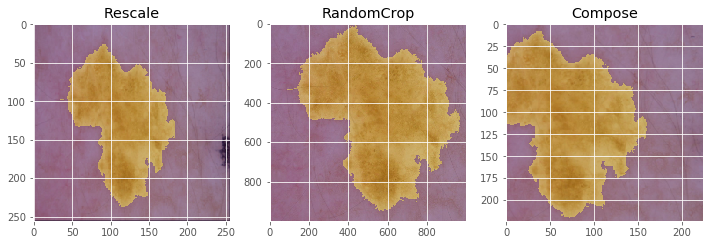

In [46]:
'''
Transformation demo
'''
scale = Rescale((256, 256))
crop = RandomCrop(1000)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])
# Apply each of the above transforms on sample.
sample = isic_dataset[21]

fig, ax = plt.subplots(1,3, figsize=(12,6))

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax[i].set_title(type(tsfrm).__name__)
    show_imgmask(transformed_sample['image'], transformed_sample['mask'], ax[i])

plt.show()

In [49]:
'''
Make real generators for dataset
'''
train_set = ISICDataset(imgs_dir, 
                        mask_dir, 
                        info[:1000], 
                        transform=transforms.Compose([
                            Rescale((256,256)),
                            ToTensor()
                        ]))

test_set = ISICDataset(imgs_dir, 
                        mask_dir, 
                        info[1000:], 
                        transform=transforms.Compose([
                            Rescale((256,256)),
                            ToTensor()
                        ]))

# U-net
inspired by https://github.com/choosehappy/PytorchDigitalPathology/tree/master/segmentation_epistroma_unet

In [176]:
from unet import UNet # https://github.com/jvanvugt/pytorch-unet

In [245]:
'''
Parameters for U-net
'''
n_classes = 2 # number of calsses in the mask
in_channels = 3 # input channals data (rgb: 3)
padding = True
depth = 5 # depth of net
wf = 2 # number of filters in first layer 2**wf 
up_mode = 'upconv' # upsample of interpolation: 'upconv', 'upsample'
batch_norm = True # batchnorm beween layers

'''
Parameters for training
'''
batch_size = 64
n_epoch = 50

In [246]:
'''
Prepare device
'''
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(0))
    torch.cuda.set_device(0)
    device = torch.device(f'cuda:{0}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='GeForce RTX 2080', major=7, minor=5, total_memory=7979MB, multi_processor_count=46)


In [247]:
'''
Define model, optimizer and loss function
'''
model = UNet(in_channels, n_classes, depth, wf, padding, batch_norm, up_mode).to(device)

print('Total params:\t{}'.format(sum([np.prod(p.size()) for p in model.parameters()])))

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

Total params:	122466


In [248]:
'''
Batch training generator
'''

params = {
    'batch_size': batch_size,
    'shuffle': False,
    'num_workers': 12,
    'drop_last': True
}

train_generator = torch.utils.data.DataLoader(train_set, **params)

In [ ]:
'''
Train model
'''
total_loss = []

for epoch in range(n_epoch):
    total_loss += [0.0]

    for sample in train_generator:
        img, msk = sample['image'].to(device), sample['mask'].to(device) 
    
        # forward
        y_pred = model(img)

        # loss
        loss = criterion(y_pred, msk)        
        total_loss[-1] += loss

        # update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('{:4d}. Loss: {:3.5f}'.format(epoch, total_loss[-1]))

   0. Loss: 10.27294
   1. Loss: 9.70463
   2. Loss: 9.30995
   3. Loss: 8.92068
   4. Loss: 8.73021
   5. Loss: 8.45148
   6. Loss: 8.01850
   7. Loss: 7.76945
   8. Loss: 7.53419
   9. Loss: 7.13752
  10. Loss: 7.02596
  11. Loss: 6.64288
  12. Loss: 6.33766
  13. Loss: 6.09410
  14. Loss: 5.72998
  15. Loss: 5.64198
  16. Loss: 5.42946
  17. Loss: 5.32081
  18. Loss: 5.03861
  19. Loss: 4.90309
  20. Loss: 4.53806
  21. Loss: 4.30914
  22. Loss: 4.05857
  23. Loss: 3.90541
  24. Loss: 3.78435


In [ ]:
PATH = './models/unet_{}_{}_{}.pth'.format(depth, n_epoch, 1000)
torch.save(model.state_dict(), PATH)

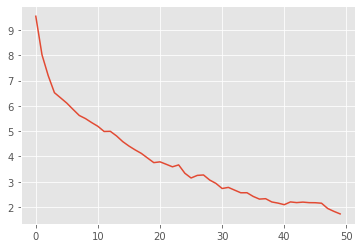

In [190]:
plt.plot(total_loss)

In [ ]:
'''
Test model
'''

In [191]:
# Original dice score (1 - same, 0 - different)
def dice_score(input, target):
    smooth = 1.
    intersection = (input * target).sum()
    
    return ((2. * intersection + smooth) /
              (input.sum() + target.sum() + smooth))

In [174]:
info

,isic_id,age_approx,anatom_site_general,benign_malignant,diagnosis,diagnosis_confirm_type,melanocytic,sex
0,ISIC_0000000,55.0,anterior torso,benign,nevus,NaN,True,female
1,ISIC_0000001,30.0,anterior torso,benign,nevus,NaN,True,female
2,ISIC_0000002,60.0,upper extremity,malignant,melanoma,histopathology,True,female
3,ISIC_0000003,30.0,upper extremity,benign,nevus,NaN,True,male
4,ISIC_0000004,80.0,posterior torso,malignant,melanoma,histopathology,True,male
...,...,...,...,...,...,...,...,...
1995,ISIC_0001995,10.0,NaN,benign,nevus,single image expert consensus,True,female
1996,ISIC_0001996,15.0,NaN,benign,nevus,single image expert consensus,True,female
1997,ISIC_0001997,15.0,NaN,benign,nevus,single image expert consensus,True,female
1998,ISIC_0001998,15.0,NaN,benign,nevus,single image expert consensus,True,female


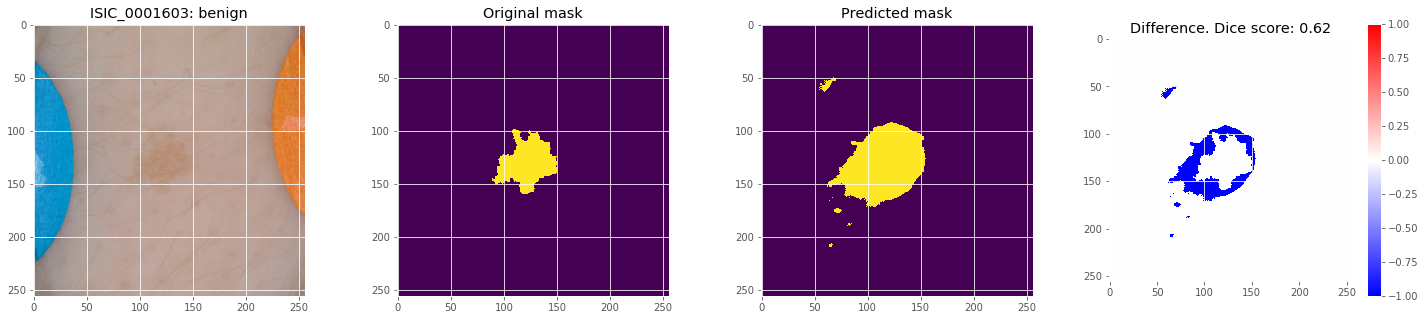

In [223]:
index = 1603 # 1128 1132 1181
sample = test_set[index] 
image, mask = sample['image'], sample['mask']

in_img = image.detach().numpy().transpose(1,2,0)
true_mask = mask.numpy()
in_img.shape
img = image.unsqueeze(0).to(device)
y_pred = model(img)
pred_mask = y_pred.squeeze(0).clone()
pred_mask = pred_mask.detach().cpu().numpy().transpose(1,2,0)
pred_mask = np.round(pred_mask)
pred_mask = np.array(pred_mask > 0, dtype=int)

# info about image
diagnosis = info['benign_malignant'][index]
img_id = info['isic_id'][index]

# plot
fig, ax = plt.subplots(1, 4, figsize=(25,5))

ax[0].imshow(in_img)
ax[0].set_title(img_id+': '+diagnosis)
ax[1].imshow(true_mask)
ax[1].set_title('Original mask')
ax[2].imshow(pred_mask[:,:,1])
ax[2].set_title('Predicted mask')
im = ax[3].imshow(true_mask - pred_mask[:,:,1], 'bwr', vmin=-1,vmax=1)
ax[3].set_title('Difference. Dice score: {:2.2f}'.format(dice_score(pred_mask[:,:,1], true_mask)))
plt.colorbar(im)
plt.show()

In [238]:
'''
(DSC) Dice loss
'''
def dice_loss(pred_mask, true_mask):
    # 
    return (((pred_mask[-1][1] > 0).float() * true_mask[-1]).sum() + 1) / \
            ( (pred_mask[-1][1] > 0).float().sum() + true_mask[-1].sum()+1)

# print(y_pred.shape)
# print(msk.shape)

print( (((y_pred[-1][1] > 0).float() * msk[-1]).sum() + 1) / ( (y_pred[-1][1] > 0).float().sum() + msk[-1].sum()+1) )

# pred_mask[-1][1] > 0

tensor(0.0143, device='cuda:0')


In [240]:
'''
TEST
'''
total_dice_score = 0.0
with torch.no_grad():
    for i in range(1000, 1500): # 100 test images
        sample = test_set[i]
        image, mask = sample['image'], sample['mask']

        # [N, 3, H, W] - image
        # [N, H, W] - mask with classes (0, 1)
        img = image.unsqueeze(0).to(device)
        msk = mask.unsqueeze(0).to(device)

        y_pred = model(img)

        # Compute Dice
#         true_mask = mask.numpy()#.squeeze(0)
#         pred_mask = y_pred.squeeze(0).clone()
#         pred_mask = pred_mask.detach().cpu().numpy().transpose(1,2,0)
#         pred_mask = np.round(pred_mask)
#         pred_mask = np.array(pred_mask > 0, dtype=int)

#         dice = dice_loss(pred_mask[:,:,1], true_mask)
        dice = dice_loss(y_pred, msk)
        total_dice_score += dice
        
        if i % 10 == 9:
            print(i, total_dice_score/(i-900))
    
print('Total test dice loss: {:2.6f}'.format(total_dice_score / 500))


1009 tensor(0.0067, device='cuda:0')
1019 tensor(0.0085, device='cuda:0')
1029 tensor(0.0130, device='cuda:0')
1039 tensor(0.0172, device='cuda:0')
1049 tensor(0.0195, device='cuda:0')
1059 tensor(0.0209, device='cuda:0')
1069 tensor(0.0227, device='cuda:0')
1079 tensor(0.0279, device='cuda:0')
1089 tensor(0.0287, device='cuda:0')
1099 tensor(0.0322, device='cuda:0')
1109 tensor(0.0493, device='cuda:0')
1119 tensor(0.0590, device='cuda:0')
1129 tensor(0.0692, device='cuda:0')
1139 tensor(0.0829, device='cuda:0')
1149 tensor(0.0955, device='cuda:0')
1159 tensor(0.1060, device='cuda:0')
1169 tensor(0.1084, device='cuda:0')
1179 tensor(0.1108, device='cuda:0')
1189 tensor(0.1115, device='cuda:0')
1199 tensor(0.1094, device='cuda:0')
1209 tensor(0.1100, device='cuda:0')
1219 tensor(0.1116, device='cuda:0')
1229 tensor(0.1110, device='cuda:0')
1239 tensor(0.1101, device='cuda:0')
1249 tensor(0.1094, device='cuda:0')
1259 tensor(0.1091, device='cuda:0')
1269 tensor(0.1080, device='cuda:0')
1